First of all we will do a model exploration in a base case (no policies implemented); <br/>
Next we will do a model exploration with random policies; <br/>
after a sensitivity and vulnerability analysis will be done; <br/>
at last a Optimization will be run to find optimal solutions. <br/>

# 1. Model exploration

In [1]:
# initialize for this run
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench import Model, RealParameter, ScalarOutcome, CategoricalParameter, IntegerParameter, BooleanParameter, Policy
from SALib.analyze import sobol

from ema_workbench.analysis import prim
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties

from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

from dike_model_function import DikeNetwork

from ProblemFormulationSelf import problem_definition
from helper import agg
from helper import plot_sob

from ema_workbench import save_results
from ema_workbench.util.utilities import load_results

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## 1.1 Base case: No policy 

In [52]:
#dike_model, planning_steps = problem_definition('all vars')

#policies_0 = [Policy('no policy', **{l.name: 0 for l in dike_model.levers})]
 
#with MultiprocessingEvaluator(dike_model) as evaluator:
    #all_results_0 = evaluator.perform_experiments(scenarios = 1000, policies = policies_0)

#save_results(all_results_0, './data/exp/nopol1000scen.tar.gz')

# Ensure variable is defined
#try:
    #all_results_0
#except NameError:
   # all_results_0 = None

# Test whether variable is defined to be None
#if all_results_0 is None:
all_results_0 = load_results('./data/exp/nopol1000scen.tar.gz')
experiments_0, outcomes_0 = all_results_0

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\nopol1000scen.tar.gz


### Plot the outcomes from no policy scenarios 

Because the outcomes are too disaggregated to be plotted, the outcomes are aggregated into different catagories

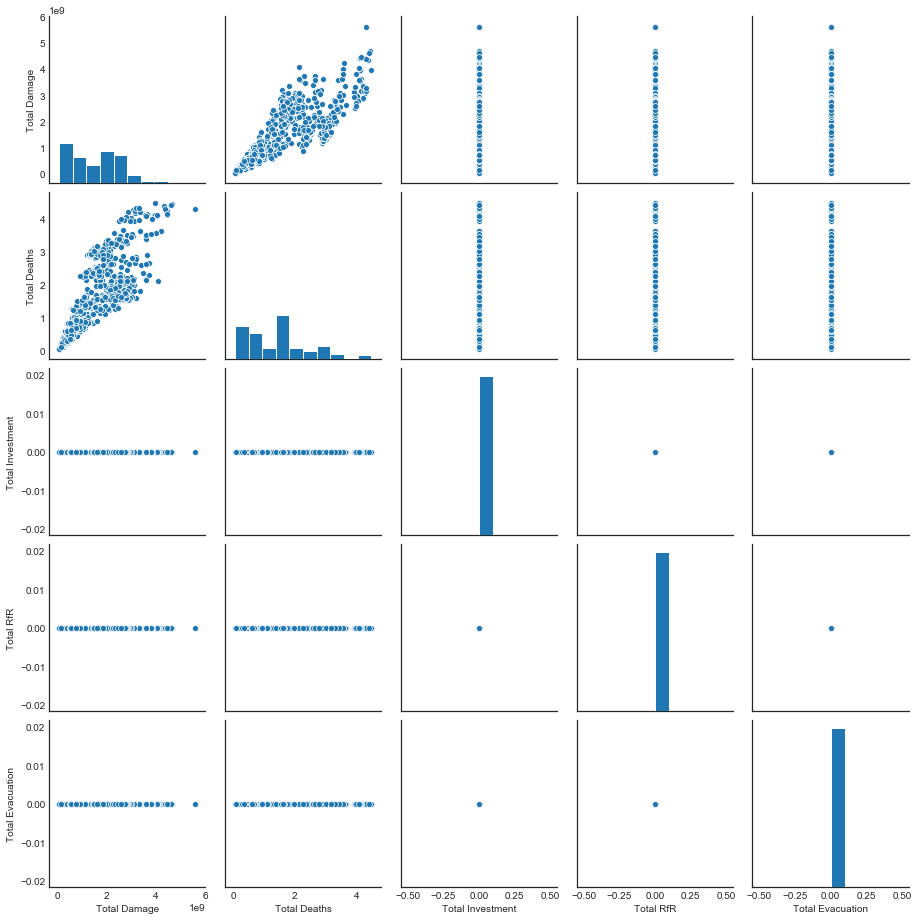

In [134]:
data = pd.DataFrame.from_dict(outcomes_0)

dam_list = ['Damage','Deaths','Investment','RfR','Evacuation']
data = agg(data, dam_list)

sns.pairplot(data, vars=list(data.columns), diag_kind='hist')
plt.show()

##### Since there is no policy being implemented, "total-investment", "total-RFR" and "total-evacuation" are zero. And we take a closer look at the damages and deaths

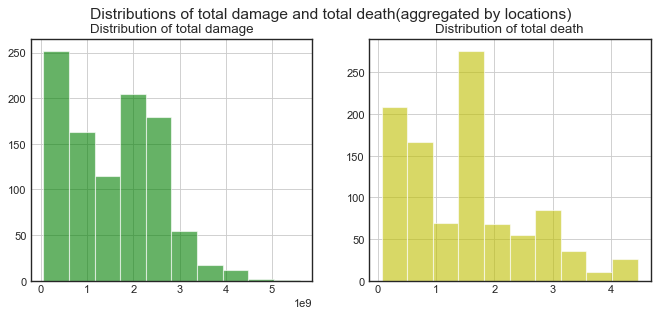

In [139]:
plt.figure(figsize=(10,4), dpi=80)
plt.suptitle('Distributions of total damage and total death(aggregated by locations)', fontsize=14)

plt.figure(1)
ax1 = plt.subplot(121)
data['Total Damage'].hist(color="g", alpha = 0.6)
plt.title('Distribution of total damage')

ax2 = plt.subplot(122)
data['Total Deaths'].hist(color="y", alpha = 0.6)
plt.title('Distribution of total death')
plt.savefig("distributions_NoPolicy")

#### Expected Damage/Death at each location

In [151]:
outcome_damage = pd.DataFrame.from_dict(outcomes_0)
agg_list = ['A.1_Expected Annual Damage','A.2_Expected Annual Damage','A.3_Expected Annual Damage',
           'A.4_Expected Annual Damage','A.5_Expected Annual Damage']

outcome_damage = agg(outcome_damage,agg_list)
outcome_damage = outcome_damage.iloc[:, -5:]
outcome_damage = outcome_damage.rename(columns=lambda x: x.replace('_Expected Annual', ''))

In [145]:
outcome_damage = pd.DataFrame.from_dict(outcomes_0)
agg_list_death = ['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths',
           'A.4_Expected Number of Deaths','A.5_Expected Number of Deaths']

outcome_death = agg(outcome_damage,agg_list_death)
outcome_death = outcome_death.iloc[:, -5:]
outcome_death = outcome_death.rename(columns=lambda x: x.replace('_Expected Number of Deaths', ''))

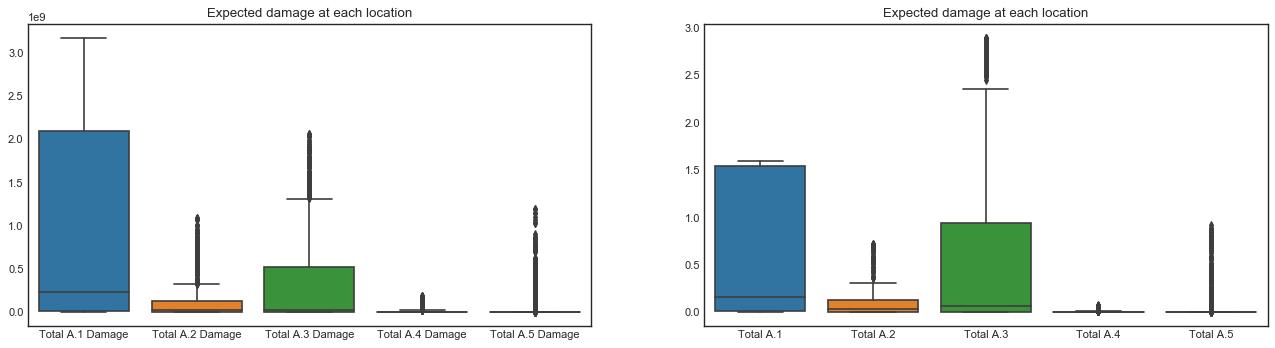

In [156]:
plt.figure(figsize=(20,5), dpi=80)
plt.figure(1)

ax1 = plt.subplot(121)
ax1 = sns.boxplot(data = outcome_damage)
ax1.set_title('Expected damage at each location')


ax2 = plt.subplot(122)
ax2 = sns.boxplot(data = outcome_death)
ax2.set_title('Expected damage at each location')

plt.savefig("boxplot_NoPolicy")

## 1.2 Ten random policies

run with 10 ramdom policies

In [49]:
# with MultiprocessingEvaluator(dike_model) as evaluator:
    #all_results_r10 = evaluator.perform_experiments(scenarios=10000,               #500
                                           # policies=10,
                                           # uncertainty_sampling='mc', reporting_interval=10000)

#from ema_workbench import save_results

#ave_results(all_results_r10, './data/exp/mc10pol10000scen.tar.gz')

#try:
    #all_results_r10
#except NameError:
    #all_results_r10 = None

# Test whether variable is defined to be None
#if all_results_10 is None:

all_results_r10 = load_results('./data/exp/mc10pol10000scen.tar.gz')
experiments_r10, outcomes_r10 = all_results_r10

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\mc10pol10000scen.tar.gz


In [172]:
data_r10 = pd.DataFrame.from_dict(outcomes_r10)
dam_list = ['Damage','Deaths','Investment','RfR','Evacuation']

data_r10 = agg(data_r10, dam_list)


[MainProcess/INFO] no time dimension found in results


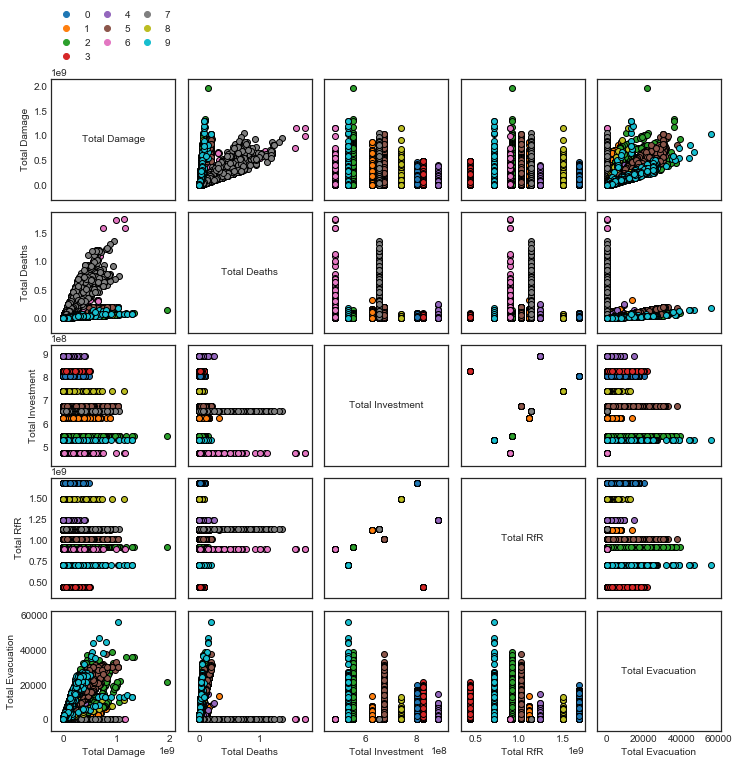

In [173]:
from ema_workbench.analysis import pairs_plotting

new_outcomes_r10 = {col:np.array(data_r10[col].tolist()) for col in data_r10.columns}

fig, ax = pairs_plotting.pairs_scatter(experiments_r10, new_outcomes_r10, group_by='policy', legend=True)
fig.set_size_inches([12, 12])
plt.savefig("ScatterPlotting")

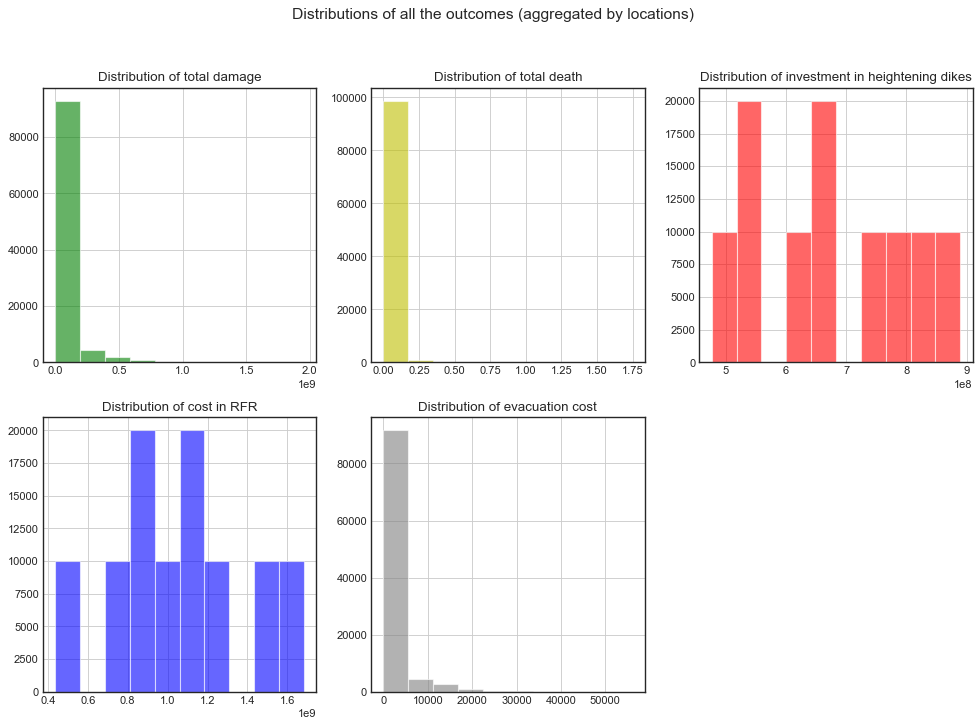

In [165]:
# Add some titles for the figures

import matplotlib.pyplot as plt 

plt.figure(figsize=(15,10), dpi=80)
plt.suptitle('Distributions of all the outcomes (aggregated by locations)', fontsize=14)
plt.figure(1)
ax1 = plt.subplot(231)
data_r10['Total Damage'].hist(color="g", alpha = 0.6)
plt.title('Distribution of total damage')

ax2 = plt.subplot(232)
data_r10['Total Deaths'].hist(color="y",alpha = 0.6)
plt.title('Distribution of total death')

ax3 = plt.subplot(233)
data_r10['Total Investment'].hist(color="r",alpha = 0.6)
plt.title('Distribution of investment in heightening dikes')

ax4 = plt.subplot(234)
data_r10['Total RfR'].hist(color="b",alpha = 0.6)
plt.title('Distribution of cost in RFR')

ax5 = plt.subplot(235)
data_r10['Total Evacuation'].hist(color="grey",alpha = 0.6)
plt.title('Distribution of evacuation cost')

plt.savefig("distributions_10policies")

In [168]:
data_r10['Total Deaths'].mean()

0.016168326507220207

##### Compared the distributions of total damage/death of 10 polices and those of no policy, we can clearly find the damages and casualties are ruduced by these policies 

# 2. Vulnerability & Sensitivity Analysis

## 2.1 scenario discovery


##### In this section, scenario discovery is applied to investigate the worst scenarios in terms of the most damage, the most deaths and the most cost. Both the no-policy base case and the 10-random-policies case will be studied.

In [5]:
all_results_0 = load_results('./data/exp/nopol1000scen.tar.gz')
experiments_0, outcomes_0 = all_results_0

all_results_r10 = load_results('./data/exp/mc10pol10000scen.tar.gz')
experiments_r10, outcomes_r10 = all_results_r10

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\nopol1000scen.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\mc10pol10000scen.tar.gz


In [178]:
data_0 = pd.DataFrame.from_dict(outcomes_0)
data_r10 = pd.DataFrame.from_dict(outcomes_r10)

filter_list = ['Damage','Deaths','Cost']

data_0 = agg(data_0, filter_list)
data_r10 = agg (data_r10,filter_list)

##### To determine the thresholds, in our analysis, we looked at approximatley 60% worst scenrios. That is, there are around 60% values above the thresholds we selected.

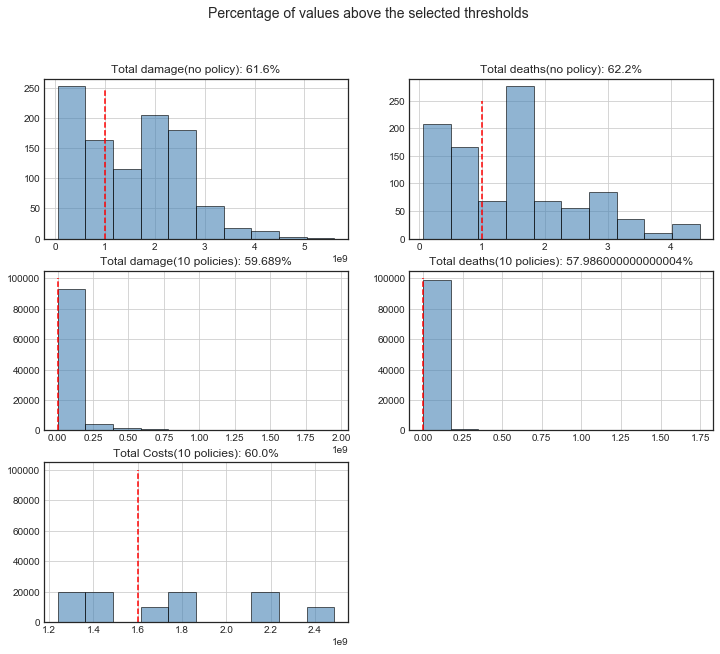

In [65]:
# check threshold vs distribution of expected damage/deaths/costs

plt.figure(figsize=(12, 10))
plt.suptitle('Percentage of values above the selected thresholds', fontsize=14)

plt.subplot(321)
data_0['Total Damage'].hist(color = 'steelblue',edgecolor='black', alpha = 0.6)
plt.vlines(1e9, 0, 250, colors = "r", linestyles = "dashed")
percentage_1 = (np.sum(data_0['Total Damage']> 1e9)/len(data_0['Total Damage']))* 100
plt.title('Total damage(no policy): '+ str(percentage_1)+ '%')

plt.subplot(322)
data_0['Total Deaths'].hist(color = 'steelblue',edgecolor='black', alpha = 0.6)
plt.vlines(1, 0, 250, colors = "r", linestyles = "dashed")
percentage_2 = (np.sum(data_0['Total Deaths']> 1)/len(data_0['Total Deaths']))* 100
plt.title('Total deaths(no policy): '+ str(percentage_2)+ '%')


plt.subplot(323)
data_r10['Total Damage'].hist(color = 'steelblue',edgecolor='black', alpha = 0.6)
plt.vlines(4e6, 0, 1e5, colors = "r", linestyles = "dashed")
percentage_3 = (np.sum(data_r10['Total Damage']> 4e6)/len(data_r10['Total Damage']))* 100
plt.title('Total damage(10 policies): '+ str(percentage_3)+ '%')

plt.subplot(324)
data_r10['Total Deaths'].hist(color = 'steelblue',edgecolor='black', alpha = 0.6)
plt.vlines(0.001, 0, 1e5, colors = "r", linestyles = "dashed")
percentage_4 = (np.sum(data_r10['Total Deaths']> 0.001)/len(data_r10['Total Deaths']))* 100
plt.title('Total deaths(10 policies): '+ str(percentage_4)+ '%')

plt.subplot(325)
data_r10['Total Cost'].hist(color = 'steelblue',edgecolor='black', alpha = 0.6)
plt.vlines(1.6e9, 0, 1e5, colors = "r", linestyles = "dashed")
percentage_5 = (np.sum(data_r10['Total Cost']> 1.6e9)/len(data_r10['Total Cost']))* 100
plt.title('Total Costs(10 policies): '+ str(percentage_5)+ '%')

plt.show()


In [54]:
# Set all the thresholds
x_0 =  experiments_0.iloc[:, 0: 48]
y_death_0 = data_0['Total Deaths'] > 1
y_damage_0 = data_0['Total Damage']>1000000000

x_r10 =  experiments_r10.iloc[:, 0: 48]
y_death_r10 = data_r10['Total Deaths'] > 0.001
y_damage_r10 = data_r10['Total Damage']>4000000
y_cost_r10 = data_r10['Total Cost']>1600000000

#### Scenario 1: Total death > 1 (no policy)

[MainProcess/INFO] 1000 points remaining, containing 622 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.28, coverage: 0.45016077170418006, density: 1.0 restricted_dimensions: 2


<function matplotlib.pyplot.show(*args, **kw)>

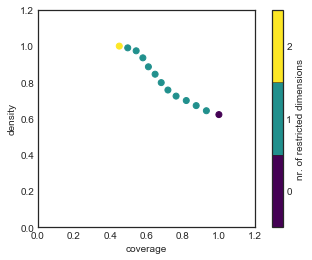

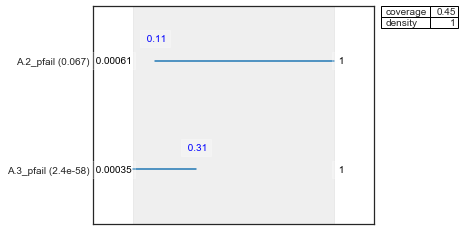

In [55]:
prim_death_0 = prim.Prim(x_0, y_death_0, threshold=0.3, peel_alpha=0.1)
box_death_0 = prim_death_0.find_box()

box_death_0.show_tradeoff()
box_death_0.inspect(style='graph')

plt.show

In [56]:
# Run this cell for an interactive figure
box_death_0.inspect_tradeoff()

alt.VConcatChart(...)

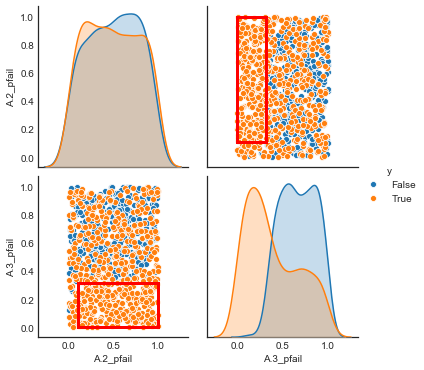

<Figure size 432x288 with 0 Axes>

In [175]:
box_death_0.show_pairs_scatter()
plt.show()

###### This PRIM subspace partitioning reveals that the dike failure probility of A2 and A3 each plays an important role in defining high deaths scenrios under no policy case

#### Scenario 2: Total damage > 1 billion (no policy)

[MainProcess/INFO] 1000 points remaining, containing 616 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.386, coverage: 0.6266233766233766, density: 1.0 restricted_dimensions: 1


<function matplotlib.pyplot.show(*args, **kw)>

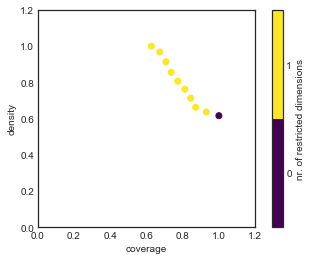

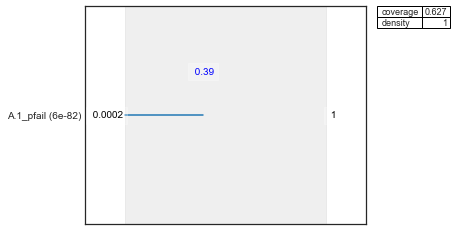

In [58]:
prim_damage_0 = prim.Prim(x_0, y_damage_0, threshold=0.3, peel_alpha=0.1)
box_damage_0 = prim_damage_0.find_box()

box_damage_0.show_tradeoff()
box_damage_0.inspect(style='graph')

plt.show

In [60]:
# Please run this for an interactive plot
box_damage_0.inspect_tradeoff()

alt.VConcatChart(...)

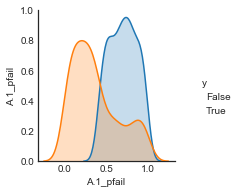

In [61]:
box_damage_0.show_pairs_scatter()
plt.show()

###### The high damage scenrios of no-policy case are mainly related to the dike failure probability of A1

#### Scenrio 3:  Death > 1  (10 policies)

[MainProcess/INFO] 100000 points remaining, containing 57986 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0846, coverage: 0.14589728555168488, density: 1.0 restricted_dimensions: 7


<function matplotlib.pyplot.show(*args, **kw)>

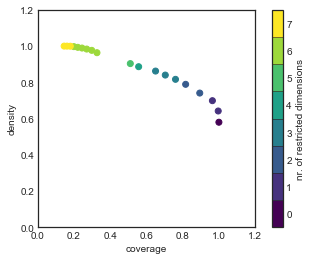

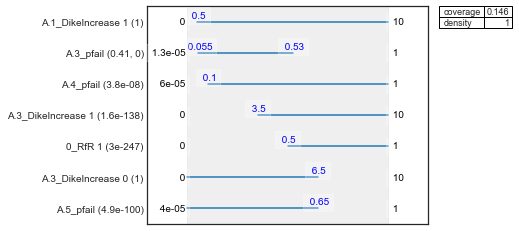

In [62]:
prim_death_r10 = prim.Prim(x_r10, y_death_r10, threshold=0.3, peel_alpha=0.1)
box_death_r10 = prim_death_r10.find_box()

box_death_r10.show_tradeoff()
box_death_r10.inspect(style='graph')

plt.show

In [63]:
# Run this cell for an interactive plot
box_death_r10.inspect_tradeoff()

alt.VConcatChart(...)

C:\Users\teres\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


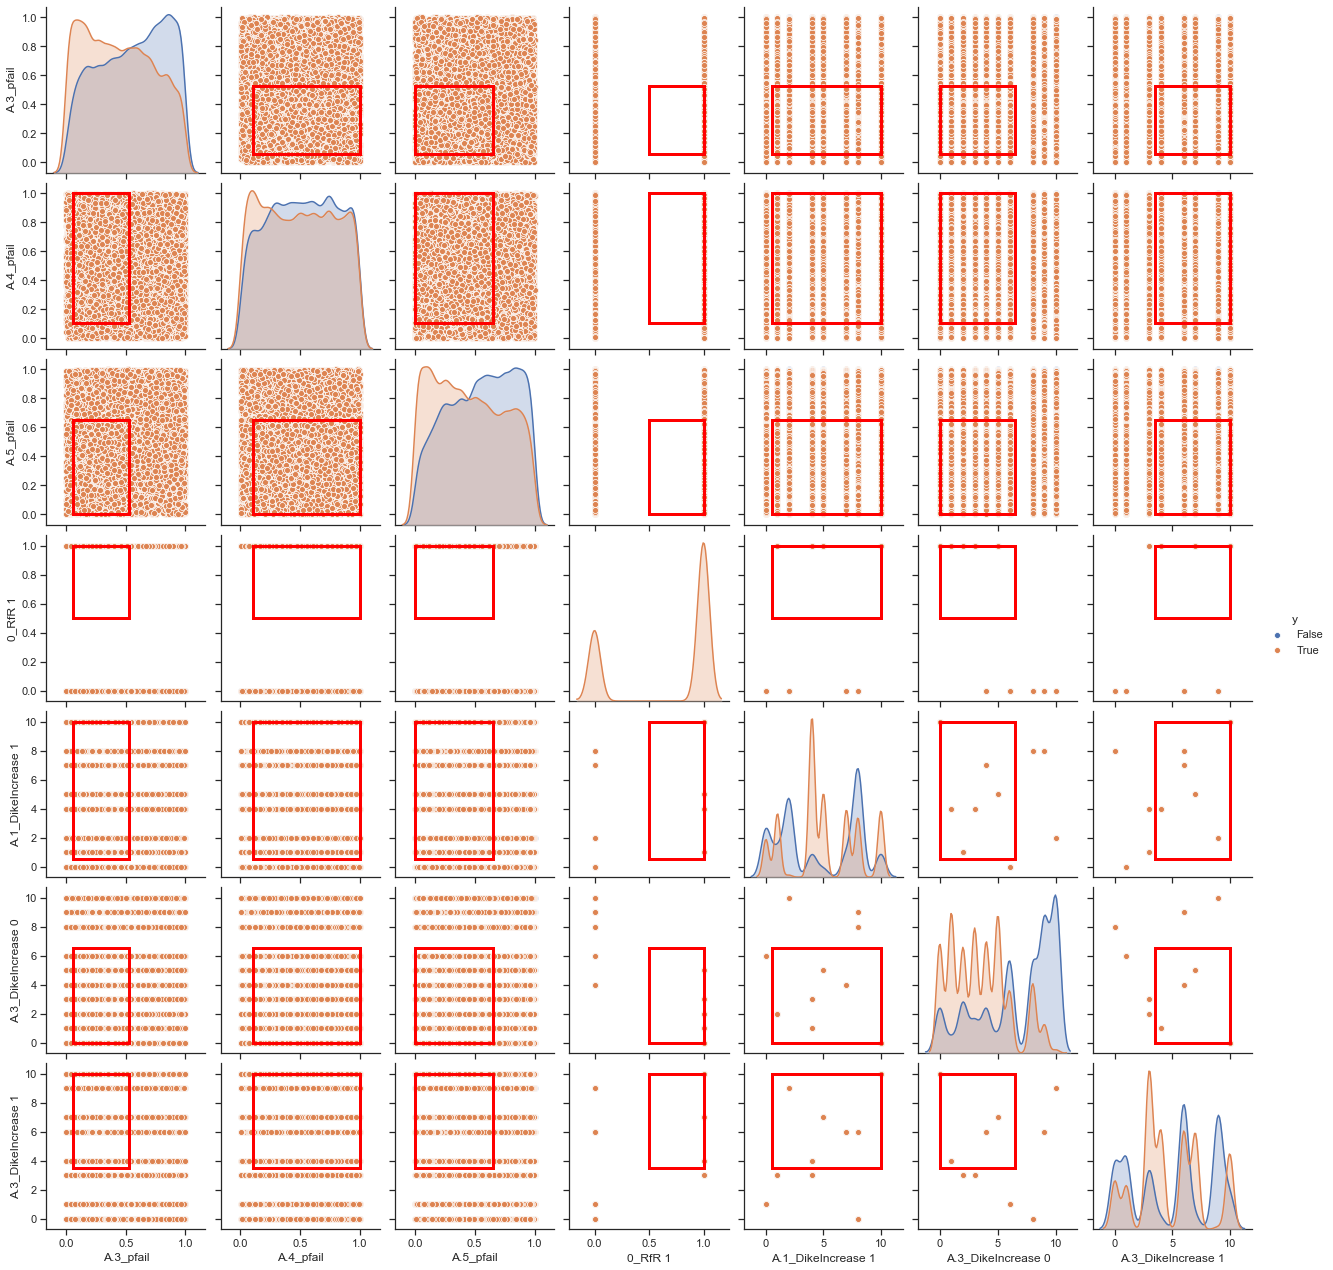

In [129]:
box_death_r10.show_pairs_scatter()
plt.show()

###### The dike failure probabilities of A3, A4 and A5, the room for river policy in dike ring 1, and raising dike policy in A1 and A3, all contributes to the high deaths scenarios. However, the pq values of A1_Dike Increase, A3_pfail and A3_DikeIncrease suggest that the inclusion of these parameters may be casued by chances.

#### Scenario 4: Total damage > 4 million (10 policies)

[MainProcess/INFO] 100000 points remaining, containing 59689 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06165, coverage: 0.10328536246209519, density: 1.0 restricted_dimensions: 5


<function matplotlib.pyplot.show(*args, **kw)>

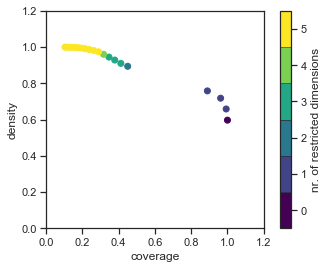

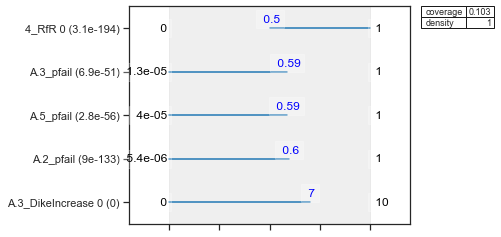

In [130]:
prim_damage_r10 = prim.Prim(x_r10, y_damage_r10, threshold=0.3, peel_alpha=0.1)
box_damage_r10 = prim_damage_r10.find_box()

box_damage_r10.show_tradeoff()
box_damage_r10.inspect(style='graph')

plt.show

In [131]:
# To see this interactive plot, please run this cell
box_damage_r10.inspect_tradeoff()

alt.VConcatChart(...)

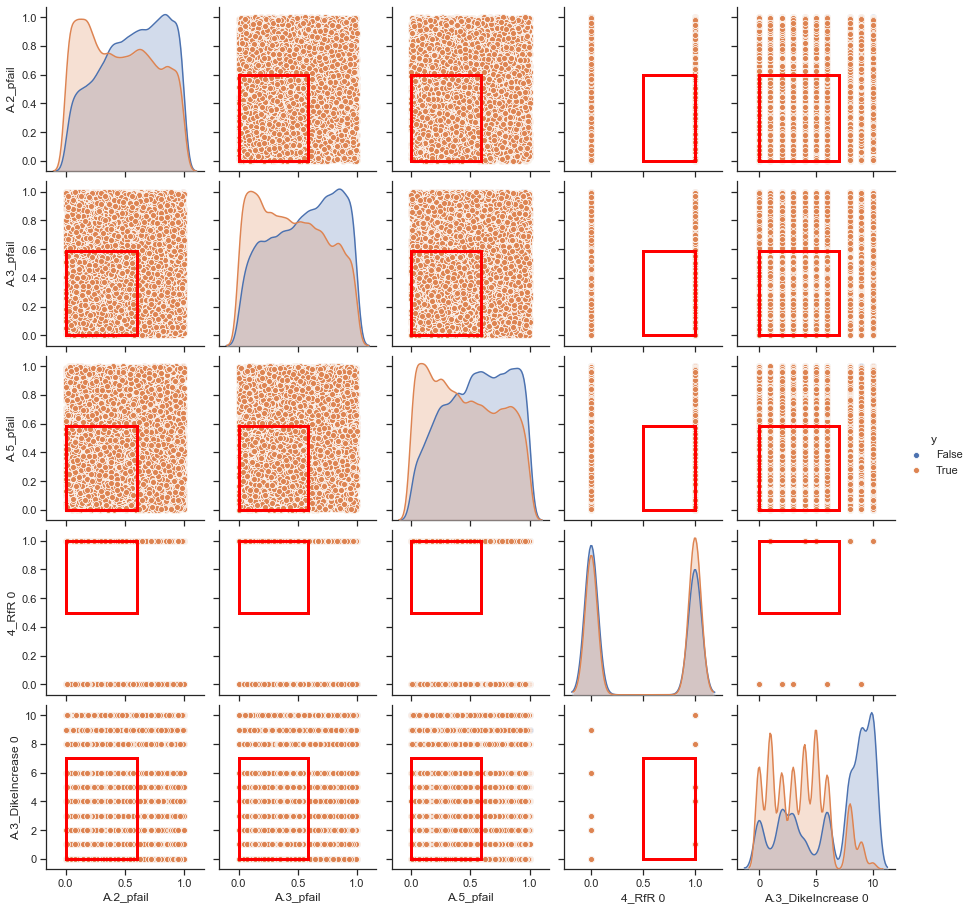

In [132]:
box_damage_r10.show_pairs_scatter()
plt.show()

###### The dike failures of A2, A3 and A5 are likely to lead to high damage scenrios. The room for river policy in dike ring 5 and A3 dike increase policy would also contribute to this, but the latter one has a pq value that indicates its inclusion of chance.

#### Scenario 5: Cost > 1.6 billion (10 policy)

[MainProcess/INFO] 100000 points remaining, containing 60000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.5, coverage: 0.8333333333333334, density: 1.0 restricted_dimensions: 1


<function matplotlib.pyplot.show(*args, **kw)>

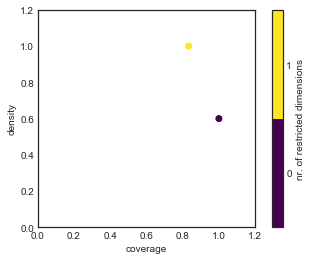

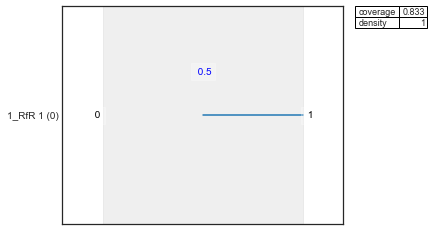

In [64]:
prim_cost_r10 = prim.Prim(x_r10, y_cost_r10, threshold=0.3, peel_alpha=0.1)
box_cost_r10 = prim_cost_r10.find_box()

box_cost_r10.show_tradeoff()
box_cost_r10.inspect(style='graph')

plt.show

In [134]:
box_cost_r10.inspect_tradeoff()

alt.VConcatChart(...)

C:\Users\teres\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\teres\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


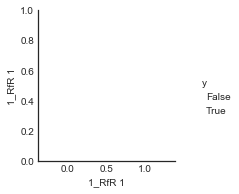

In [66]:
box_cost_r10.show_pairs_scatter()
plt.show()

###### The result shows that the high investment cost scenarios owe to the room for river policy in dike ring 2 only

## 2.2 Feature Scoring
##### To better visualize the importance of each uncertainty and lever, feature scoring is used here to show how these levers/uncertainty factors influence the outcomes ( expected damage, expected total death and expected total cost)

In [176]:
x_0 = experiments_0.drop(['scenario','policy'], axis = 1, inplace = False)
x_r10 = experiments_r10.drop(['scenario','policy'], axis = 1, inplace = False)

#### Feature scoring for no policy case

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


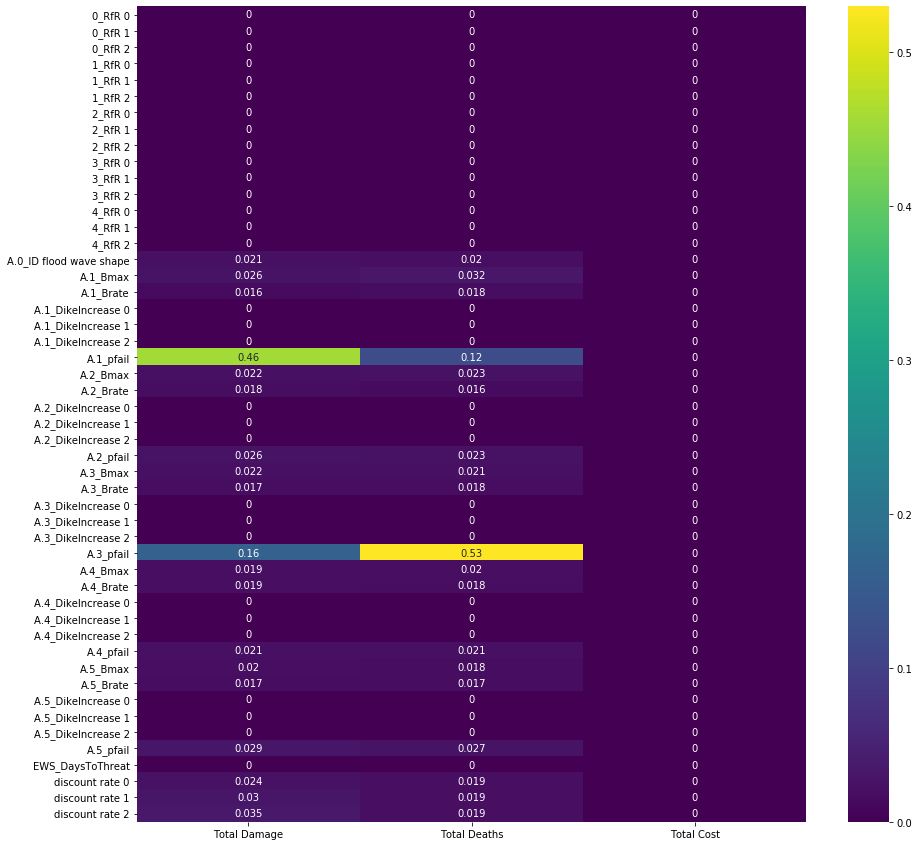

In [58]:
fs_0 = feature_scoring.get_feature_scores_all(x_0, data_0)
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(fs_0, cmap='viridis', annot=True)
plt.show()

###### Feature scoring reports:
* Total damage is associated tightlt with the dike failure probabilities of A1 and A3
* A3 failure probability will also highly impact total deaths

#### Feature scoring for ten random policies case

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


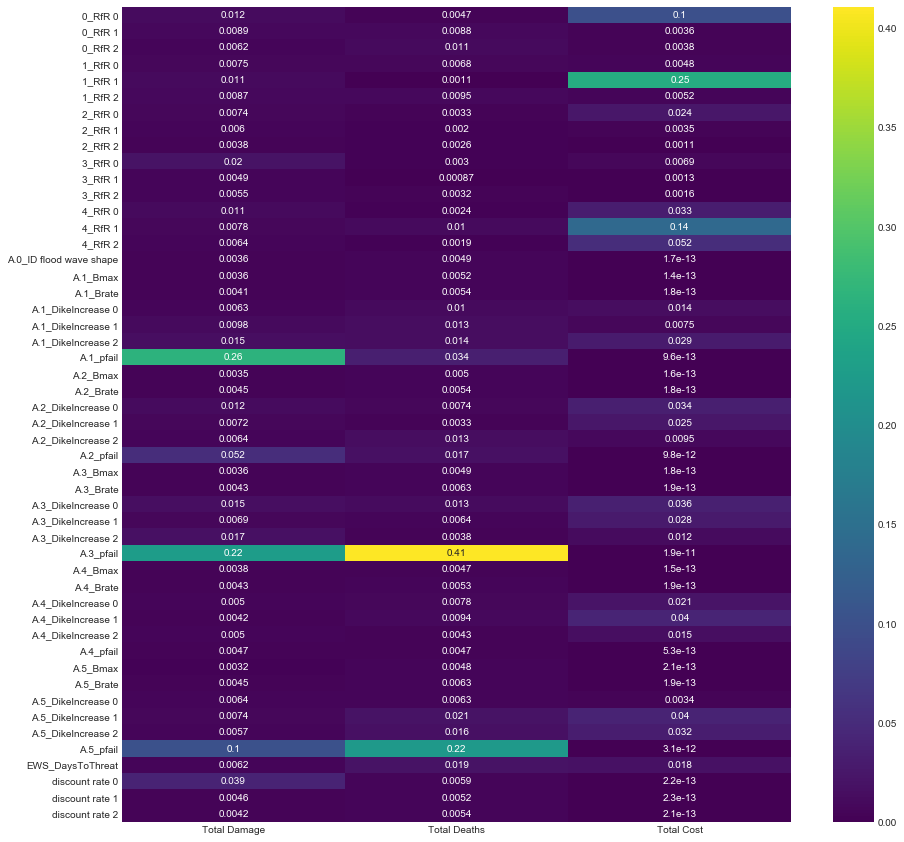

<Figure size 432x288 with 0 Axes>

In [179]:
fs_r10 = feature_scoring.get_feature_scores_all(x_r10, data_r10)
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(fs_r10, cmap='viridis', annot=True)
plt.show()

In [181]:
fig.savefig('feature_scoring_10policie')

###### * total damage is influened most the dike failure probabilities of A1, A3.
###### * The outcome of expected causalties is highly determined by the dike failure probabilities of A3, A5.
###### * Total costs of flood management (including investments in raise dikes,rfr and evacuation) are most influenced by the RfR levers at Cortenover (A.2) and Deventer (A.5).

## 3.3 Sensitivity analysis using SOBOL

To perform sobol experiments first

In [72]:
#dike_model, planning_steps = problem_definition('all vars')
#policies_0 = [Policy('no policy', **{l.name: 0 for l in dike_model.levers})]

#n_scen = 2500
#print(n_scen)
#with MultiprocessingEvaluator(dike_model) as evalu:
    #sa_results = evalu.perform_experiments(n_scen, policies=policies_0, uncertainty_sampling='sobol', reporting_interval=400)

#from ema_workbench import save_results
#save_results(sa_results, './sobolnopol4000scen.tar.gz')
# cant get this to run so i am running sobol.py

### No policy case: 

In [2]:
dike_model, planning_steps = problem_definition('all vars')

In [3]:
all_results_sobol = load_results('./data/exp/sobolnopol40000scen.tar.gz')
experiments_sobol, outcomes_sobol = all_results_sobol

[MainProcess/INFO] results loaded succesfully from c:\TEMP\Programming\EPA1361\final assignment\data\exp\sobolnopol40000scen.tar.gz


In [4]:
## To aggregate some results
data_0_sob = pd.DataFrame.from_dict(outcomes_sobol)

sobol_list = ['Damage', 'Deaths','Investment','RfR','Evacuation']
data_0_sob = agg(data_0_sob, sobol_list)

In [5]:
problem = get_SALib_problem(dike_model.uncertainties)
Si_damage = sobol.analyze(problem, np.array(data_0_sob['Total Damage']),
                   calc_second_order=True, print_to_console=False)
Si_death = sobol.analyze(problem, np.array(data_0_sob['Total Deaths']),
                   calc_second_order=True, print_to_console=False)

In [6]:
Si_damage_filter = {k:Si_damage[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_damage_df = pd.DataFrame(Si_damage_filter, index = problem['names'])
# Si_damage_df

Si_death_filter = {k:Si_death[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_death_df = pd.DataFrame(Si_death_filter, index = problem['names'])

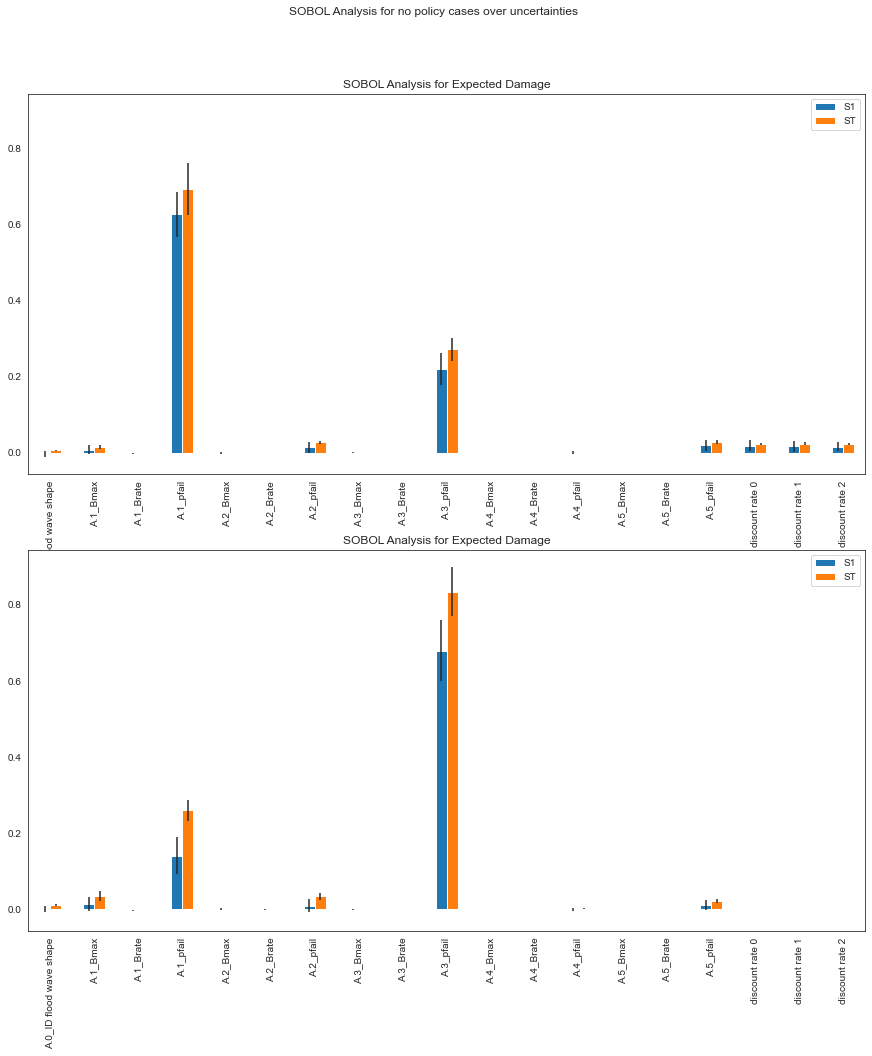

In [7]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots(2, 1, sharey=True) #figsize=(12, 10))
ax[0].set_title('SOBOL Analysis for Expected Damage')
ax[1].set_title('SOBOL Analysis for Expected Damage')

plot_sob(Si_damage_df, ax = ax[0])
plot_sob(Si_death_df,ax = ax[1])

fig.set_size_inches(15,15)
fig.subplots_adjust(top=0.9)
fig.suptitle('SOBOL Analysis for no policy cases over uncertainties')
plt.show()


### Ten policies case

In [117]:
all_results_sobol_pol = load_results('./data/exp/sobolpol40000scen.tar.gz')
experiments_sobol_pol, outcomes_sobol_pol = all_results_sobol_pol

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\sobolpol40000scen.tar.gz


In [126]:
data_r10_sob = pd.DataFrame.from_dict(outcomes_sobol_pol)

sobol_list = ['Damage', 'Deaths','Costs']
data_r10_sob = agg(data_r10_sob, sobol_list)


In [127]:
problem = get_SALib_problem(dike_model.uncertainties)
Si_damage_1 = sobol.analyze(problem, np.array(data_r10_sob['Total Damage']),
                   calc_second_order=True, print_to_console=False)
Si_death_1 = sobol.analyze(problem, np.array(data_r10_sob['Total Deaths']),
                   calc_second_order=True, print_to_console=False)
Si_cost_1 = sobol.analyze(problem, np.array(data_r10_sob['Total Costs']),
                   calc_second_order=True, print_to_console=False)

In [128]:
Si_damage_filter_1 = {k:Si_damage_1[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_damage_df_1 = pd.DataFrame(Si_damage_filter_1, index = problem['names'])
# Si_damage_df

Si_death_filter_1 = {k:Si_death_1[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_death_df_1 = pd.DataFrame(Si_death_filter_1, index = problem['names'])

#Si_cost_filter_1 = {k:Si_cost_1[k] for k in ['ST','ST_conf','S1','S1_conf']}
#Si_cost_df_1 = pd.DataFrame(Si_cost_filter_1, index = problem['names'])

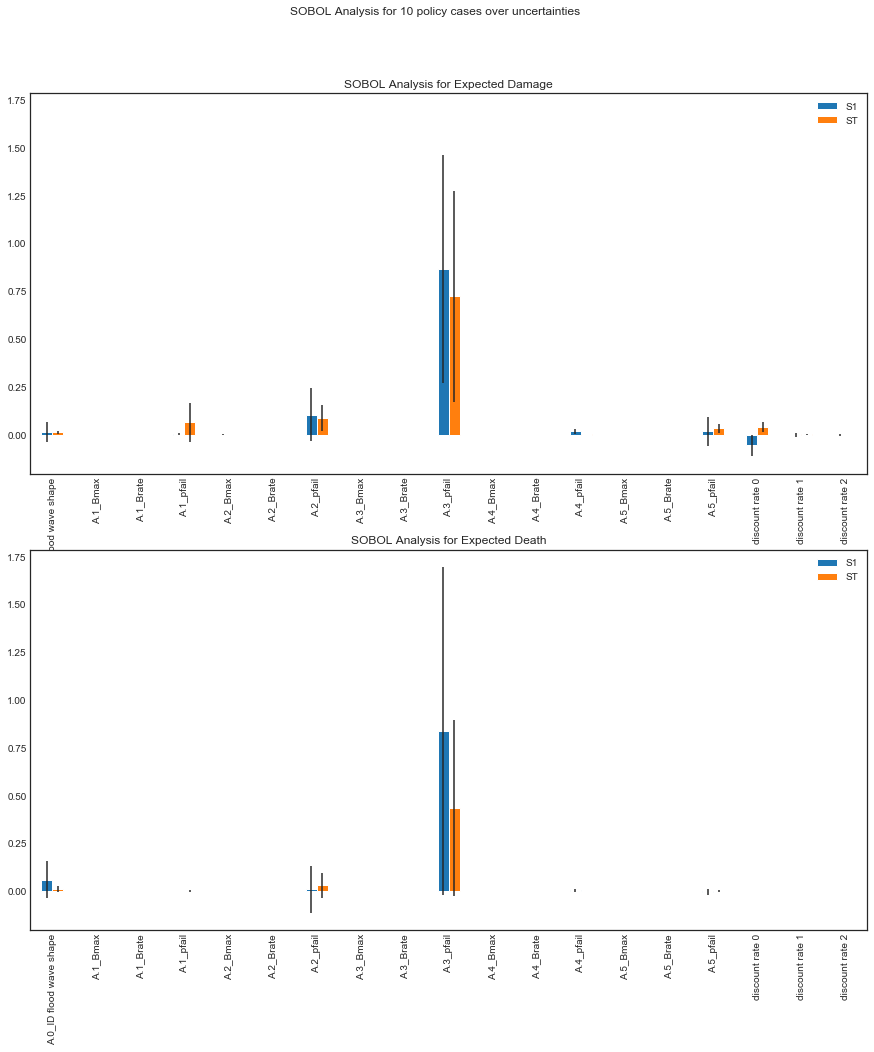

In [129]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots(2, 1, sharey=True) #figsize=(12, 10))
ax[0].set_title('SOBOL Analysis for Expected Damage')
ax[1].set_title('SOBOL Analysis for Expected Death')
#ax[2].set_title('SOBOL Analysis for Expected Costs')

plot_sob(Si_damage_df_1, ax = ax[0])
plot_sob(Si_death_df_1,ax = ax[1])
#plot_sob(Si_cost_df_1,ax = ax[2])


fig.set_size_inches(15,15)
fig.subplots_adjust(top=0.9)
fig.suptitle('SOBOL Analysis for 10 policy cases over uncertainties')
plt.show()

#### For levers: to be finished 

In [87]:
levers = []
for lever in dike_model.levers:
    levers.append(lever)

In [88]:
# I know why this does not work; sobol requires an x amount of scenarios; thus differences in levers which it does not have here. Getting that sufficient is not yet possible for me. 
problem = get_SALib_problem(levers)
Si_damage = sobol.analyze(problem, np.array(data_r10['total-damage']),
                   calc_second_order=True, print_to_console=False)
Si_death = sobol.analyze(problem, np.array(data_r10['total-death']),
                   calc_second_order=True, print_to_console=False)
Si_cost = sobol.analyze(problem, np.array(data_r10['total-cost']),
                   calc_second_order=True, print_to_console=False)

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

# optimization ( In another separate notebook)